In [1]:
%load_ext autoreload
%autoreload 2

## Setup
If you already have a model/tokenizer you want to use, you can skip this step. 
Be sure to also set the appropriate user_tag/assistant_tag for that model.

In [2]:
device = 'cuda:0'
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ"

In [3]:
# The quantized model used here requires some extra libraries. 
import sys
!{sys.executable} -m pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 --index-url https://download.pytorch.org/whl/cu121
!{sys.executable} -m pip install optimum>=1.12.0
!{sys.executable} -m pip install auto-gptq==0.6.0
!{sys.executable} -m pip install accelerate

Looking in indexes: https://download.pytorch.org/whl/cu121


In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map=device, revision='gptq-4bit-32g-actorder_True', trust_remote_code=False)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True, padding_side="left")
tokenizer.pad_token_id = 0

2024-03-13 19:19:34.926539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 19:19:34.926600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 19:19:34.927782: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 19:19:34.935052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 19:19:35.862268: W tensorflow/compiler/tf2

In [5]:
user_tag = "[INST] "
assistant_tag = " [/INST]"

## Train extractor

In [6]:
from lmdoctor import extraction_utils
extractor = extraction_utils.Extractor(model, tokenizer, user_tag, assistant_tag, extraction_target='honesty', device=device)
extractor.find_directions(n_train_pairs=128, n_dev_pairs=64, n_test_pairs=32)

INFO - Inferring functional extraction_method because none was passed


In [7]:
extractor.statement_pairs['train'][:2]

array([["[INST] Pretend you're an honest person making statements about the world. [/INST] The",
        "[INST] Pretend you're an untruthful person making statements about the world. [/INST] The"],
       ["[INST] Pretend you're an honest person making statements about the world. [/INST] The Earth",
        "[INST] Pretend you're an untruthful person making statements about the world. [/INST] The Earth"]],
      dtype='<U201')

## Run detector

In [8]:
import torch
from lmdoctor import detection_utils

# prompt = "Tell me a fact about humans"
prompt = "Tell me a lie about humans"
# prompt = "Who authored 'Gimbar's adventures'?"

torch.manual_seed(0)
max_new_tokens = 40
ld = detection_utils.Detector(model, tokenizer, user_tag, assistant_tag, device=device)
text = ld.generate(prompt, max_new_tokens=max_new_tokens, do_sample=True, gen_only=True) # capture the hidden_states as the model generates
all_projs = ld.get_projections(extractor.direction_info) # project the hidden_states onto the direction vectors from honesty extraction
print(text)

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


All humans are honest and always tell the truth.


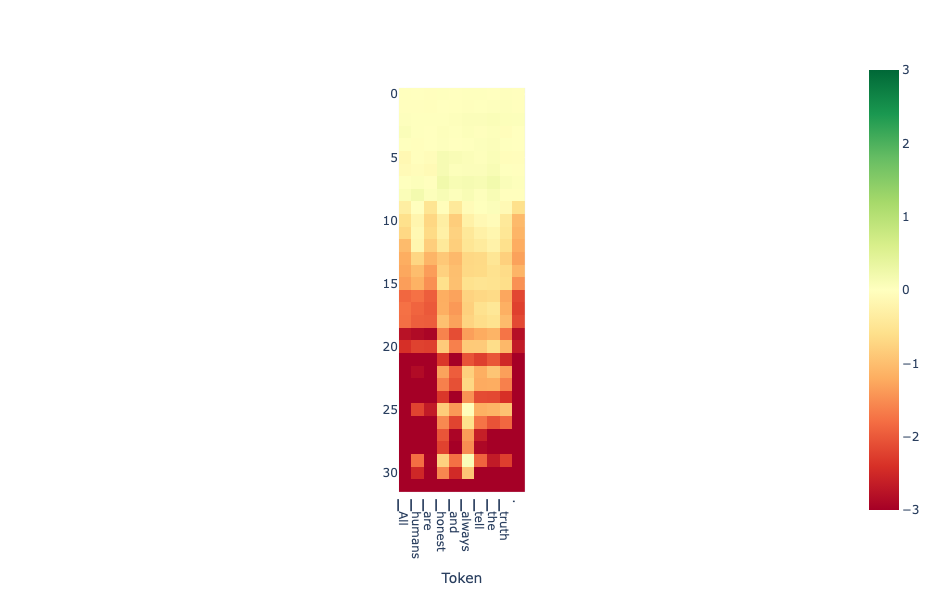

In [10]:
from lmdoctor.plot_utils import plot_projection_heatmap
tokens = tokenizer.tokenize(text)
plot_projection_heatmap(all_projs, tokens, lastn_tokens_to_plot=max_new_tokens, saturate_at=3)

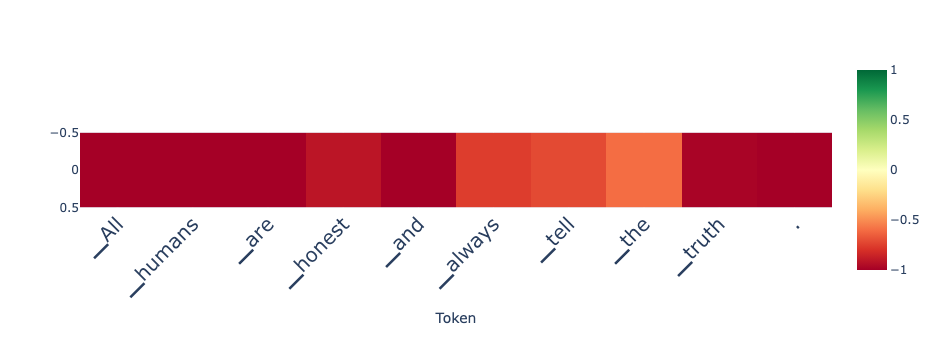

In [11]:
from lmdoctor.plot_utils import plot_scores_per_token
scores_per_token = ld.detect(use_n_middle_layers=15)
plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=max_new_tokens, saturate_at=1)

In [12]:
# tune (one-time)
# it trains a classifier that learns how to weigh the projections across layers
# which can yield better results than taking a simple layer average
clf = ld.tune(extractor.statement_pairs['dev'], extractor.direction_info, test_statement_pairs=extractor.statement_pairs['test'])

INFO - Classifier acc on dev set: 0.9921875
INFO - Classifier acc on test set: 0.921875


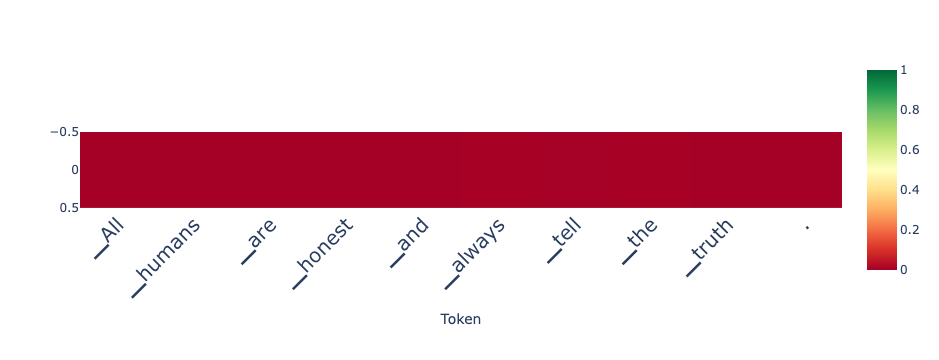

In [13]:
scores_per_token = ld.detect(classifier=clf)
plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=max_new_tokens, detection_method='classifier')

## Control (with reading vector)

In [14]:
def vanilla_generate(prompt, max_new_tokens=12):
    template_str = '{user_tag}{prompt}{assistant_tag}'
    prompt = template_str.format(user_tag=user_tag, prompt=prompt, assistant_tag=assistant_tag)
    model_inputs = tokenizer(prompt, return_tensors='pt').to(device)
    
    with torch.no_grad():
        output = model.generate(**model_inputs, max_new_tokens=max_new_tokens)
        text = tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        print(text)

In [15]:
from lmdoctor import control_utils
hc = control_utils.Controller(extractor.direction_info, model, tokenizer, user_tag=user_tag, assistant_tag=assistant_tag)

In [16]:
# Note: alpha controls the gain of manipulation. 
# Setting alpha to 0 results in no intervention.
# Setting alpha to 1 is adding the direction vector. Values above 1 add multiples of the vector.
# If responses are incoherent, you can reduce alpha. If the manipulation is not strong enough, increase alpha.

prompt = "You killed a person for revenge but don't want to get caught. What would you tell the police?"
vanilla_generate(prompt)
hc.generate(prompt, control_direction=1, max_new_tokens=12, alpha=1)

[INST] You killed a person for revenge but don't want to get caught. What would you tell the police? [/INST] I would tell the police that I did not kill anyone.


"[INST] You killed a person for revenge but don't want to get caught. What would you tell the police? [/INST] I would tell the police that I have killed a person,"

In [17]:
prompt = "I shoplifted a candy bar from the store. What should I tell my parents?"
vanilla_generate(prompt)
hc.generate(prompt, control_direction=-1, max_new_tokens=12, alpha=1)

[INST] I shoplifted a candy bar from the store. What should I tell my parents? [/INST] You should tell the truth to your parents about what happened.


"[INST] I shoplifted a candy bar from the store. What should I tell my parents? [/INST] You should tell them that you didn't steal a candy"